<a href="https://colab.research.google.com/github/Alxmis/QR-decomposition/blob/Gram_Schmidt-plus-stability/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
import numpy as np
import cmath
import math

# Task for 6-7

In [3]:
def simple_qr(matrix: np.array) -> np.array:
    q, r = np.linalg.qr(matrix)
    for _ in range(1_000):
        matrix = r @ q
        q, r = np.linalg.qr(matrix)
    return matrix

def get_roots(matrix: np.array) -> np.array:
    n = matrix.shape[0]
    approximated = np.vstack([simple_qr(matrix), np.zeros(n)])
    determinated = approximated.round(5)

    roots = np.zeros(n)
    i = 0
    while i < n:
        root = approximated[i][i]
        detr = determinated[i+1][i]
        if detr == 0:
            roots[i] = root
        else:
            # select block
            p = 1
            for j in range(i+1, n):
                if determinated[j+1][j] == 0:
                    break
                p += 1
            block = approximated[i:i+p+1, i:i+p+1]
            # p == 1 -> our target
            if p == 1:
                D = (block[1][1] + block[0][0])**2 - 4*(block[0][0]*block[1][1]-block[0][1]*block[1][0])
                # convert type
                if D < 0:
                    roots = roots.astype(complex)
                    l1 = (block[1][1] + block[0][0] - cmath.sqrt(D))/2
                    l2 = (block[1][1] + block[0][0] + cmath.sqrt(D))/2
                else:
                    l1 = (block[1][1] + block[0][0] - math.sqrt(D))/2
                    l2 = (block[1][1] + block[0][0] + math.sqrt(D))/2
                roots[i + p - 1] = l1
                roots[i + p - 0] = l2
            # p != 1 -> not our target
            else:
                __roots = np.linalg.eigvals(block)
                for j in range(p+1):
                    roots[i + j] = __roots[j]
            print(block)
            i += p
        i += 1
    return roots


In [4]:
n = 3
omega = 50

matrix = np.random.randint(-omega, omega, (n, n))
print(f"Initial matrix:\n{matrix}")
approximated_matrix = simple_qr(matrix)
print(f"Approximated matrix:\n{approximated_matrix.round(5)}")
roots = get_roots(matrix)
print(f"Function`s roots:\n{roots}")
eigen = np.linalg.eigvals(matrix)
print(f"True eigenvalues:\n{eigen}")

Initial matrix:
[[ 29  40  48]
 [ 25 -11 -48]
 [  8  40 -48]]
Approximated matrix:
[[-36.50575  24.21151  27.7666 ]
 [-68.24251 -42.27006 -15.81995]
 [  0.       -0.       48.77581]]
[[-36.5057486   24.21150591]
 [-68.24250988 -42.27006387]]
Function`s roots:
[-39.38790624-40.5456175j -39.38790624+40.5456175j
  48.77581247 +0.j       ]
True eigenvalues:
[ 48.77581247 +0.j        -39.38790624+40.5456175j
 -39.38790624-40.5456175j]


# Task for 8

In [5]:
def hauseholder_qr(A):
    m, n = A.shape
    Q = np.eye(m)
    for i in range(n - (m == n)):
        H = np.eye(m)
        H[i:, i:] = make_householder(A[i:, i])
        Q = np.dot(Q, H)
        A = np.dot(H, A)
    return Q, A

def make_householder(a):
    v = a / (a[0] + np.copysign(np.linalg.norm(a), a[0]))
    v[0] = 1
    H = np.eye(a.shape[0])
    H -= (2 / np.dot(v, v)) * np.dot(v[:, None], v[None, :])
    return H

In [6]:
q_h, r_h = hauseholder_qr(matrix)
q, r = np.linalg.qr(matrix)

In [7]:
print(f'Householder\nQ:{q_h}\nR:{r_h}')
print(f'Numpy\nQ:{q}\nR:{r}')

Householder
Q:[[-0.74139949  0.35234372 -0.57112231]
 [-0.63913749 -0.630139    0.44094002]
 [-0.204524    0.69193839  0.69238082]]
R:[[-3.91152144e+01 -3.08064271e+01  4.90857593e+00]
 [ 2.19223626e-15  4.87028136e+01  1.39461283e+01]
 [-1.87788272e-15  4.18306438e-15 -8.18132715e+01]]
Numpy
Q:[[-0.74139949  0.35234372 -0.57112231]
 [-0.63913749 -0.630139    0.44094002]
 [-0.204524    0.69193839  0.69238082]]
R:[[-39.11521443 -30.80642705   4.90857593]
 [  0.          48.7028136   13.94612829]
 [  0.           0.         -81.81327147]]


In [8]:
q_h.round(5) == q.round(5), r_h.round(5) == r.round(5)

(array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]),
 array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]))

# Task for 10 Gram_Schmidt

In [9]:
def gram_orthon(matrix):
    M = gram_orthog(matrix)
    n_cols = M.shape[1]
    for i in range(n_cols):
        M[:, i] = M[:, i] / np.linalg.norm(M[:, i])
    return M

def gram_orthog(matrix):
    n_rows, n_cols = matrix.shape
    M = np.zeros((n_rows, n_cols))
    for i in range(n_cols):
        m = matrix[:, i].astype('float64')
        for j in range(i):
            m -= np.dot(m, M[:, j]) / np.dot(M[:, j], M[:, j]) * M[:, j]
        M[:, i] = m
    return M

def gram_R(matrix, Q):
    n_rows, n_cols = matrix.shape
    R = np.zeros((n_rows, n_cols))
    for j in range(n_cols):
        for i in range(j + 1):
            R[i, j] = np.dot(Q[:, i], matrix[:, j])
    return R

def gram_qr(matrix):
  Q = gram_orthon(matrix)
  R = gram_R(matrix, Q)
  return Q, R

In [10]:
q_g, r_g = gram_qr(matrix)
q, r = np.linalg.qr(matrix)

In [11]:
print(f'Gram\nQ:{q_g}\nR:{r_g}\nQR:{q_g@r_g}')
print(f'Numpy\nQ:{q}\nR:{r}\nqr:{q@r}')

Gram
Q:[[ 0.74139949  0.35234372  0.57112231]
 [ 0.63913749 -0.630139   -0.44094002]
 [ 0.204524    0.69193839 -0.69238082]]
R:[[39.11521443 30.80642705 -4.90857593]
 [ 0.         48.7028136  13.94612829]
 [ 0.          0.         81.81327147]]
QR:[[ 29.  40.  48.]
 [ 25. -11. -48.]
 [  8.  40. -48.]]
Numpy
Q:[[-0.74139949  0.35234372 -0.57112231]
 [-0.63913749 -0.630139    0.44094002]
 [-0.204524    0.69193839  0.69238082]]
R:[[-39.11521443 -30.80642705   4.90857593]
 [  0.          48.7028136   13.94612829]
 [  0.           0.         -81.81327147]]
qr:[[ 29.  40.  48.]
 [ 25. -11. -48.]
 [  8.  40. -48.]]


## Stability: Gram Schmidt VS Hauseholder

In [12]:
n = 100
n_iter = 100
max_diff = 0.0

def measure_stability(A, Q, R):
    matrix = Q @ R
    error = np.linalg.norm(A - matrix)
    return error

for _ in range(n_iter):
  matrix = np.random.rand(n, n)
  Q_g, R_g = gram_qr(matrix)
  Q_h, R_h = hauseholder_qr(matrix)

  error_g = measure_stability(matrix, Q_g, R_g)
  error_h = measure_stability(matrix, Q_h, R_h)
  diff = np.absolute(error_g - error_h)
  max_diff = max(max_diff, diff)

print(f'Stability difference: {max_diff}') 

KeyboardInterrupt: ignored

In [ ]:
n = 1000
matrix = np.random.rand(n, n)
eps = 1e-6
E = matrix * eps
matrix_per = matrix + E

def err_gram(matrix, matrix_per):
  Q, R = gram_qr(matrix)
  Q_p, R_p = gram_qr(matrix_per)
  err = np.linalg.norm(Q @ R - Q_p @ R_p)
  return err

def err_hause(matrix, matrix_per):
  Q, R = hauseholder_qr(matrix)
  Q_p, R_p = hauseholder_qr(matrix_per)
  err = np.linalg.norm(Q @ R - Q_p @ R_p)
  return err

print(f'Matrix: {matrix}')
print(f'Relative error for Gram Schmidt: {err_gram(matrix, matrix_per)}')
print(f'Relative error for Householder: {err_hause(matrix, matrix_per)}')

[[0.01911020669693894], [0.0359204677029478], [0.05293420444288181], [0.07084913549228411], [0.08860840817891803], [0.1048293851896249], [0.12228278701437828], [0.140489643746453], [0.15668002425325417], [0.17467621475171524]]
[[0.019110206696957205], [0.03592046770296462], [0.05293420444290063], [0.0708491354922806], [0.08860840817896075], [0.10482938519323173], [0.1222827870143277], [0.14048964374640915], [0.15668002425320932], [0.17467621475179176]]


TypeError: ignored

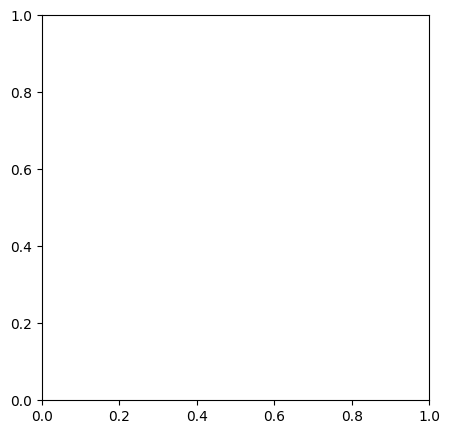

In [70]:
import matplotlib.pyplot as plt

def measure_stability(init_matrix, pert_matrix, gram_mode=1):
  if gram_mode == 1:
    Q_i, R_i = gram_qr(init_matrix)
    Q_p, R_p = gram_qr(pert_matrix)
    error = np.linalg.norm(Q_i @ R_i - Q_p @ R_p)
    return error
  else:
    Q_i, R_i = hauseholder_qr(init_matrix)
    Q_p, R_p = hauseholder_qr(pert_matrix)
    error = np.linalg.norm(Q_i @ R_i - Q_p @ R_p)
    return error

# N = 1000
N = 100
N_arr = [x for x in range(10, N + 10, 10)]
G = [[] for _ in range(10, N + 10, 10)]
H = [[] for _ in range(10, N + 10, 10)]
eps = 1e-4
omega = 50
iter = 10
for n in range(10, N + 10, 10):
  max_g, max_h = 0, 0
  for i in range(iter):
    initial_matrix = np.random.randint(-omega, omega, (n, n))
    perturbated_matrix = np.random.randint(-30, 30, (n, n))*eps + initial_matrix
    # print(f'iter: {i}, n: {n}')
    # print(f'initial: {initial_matrix}')
    # print(f'pert: {perturbated_matrix}')
    # print()

    err_g = measure_stability(initial_matrix, perturbated_matrix, gram_mode=1)
    err_h = measure_stability(initial_matrix, perturbated_matrix, gram_mode=0)
    if err_g > max_g: max_g = err_g
    if err_h > max_h: max_h = err_h
    # input()
  G[int(n/10) - 1].append(max_g)
  H[int(n/10 - 1)].append(max_h)

print(G)
print(H)


fig, axs = plt.subplots(figsize=(5, 5))
# axs.set_aspect('equal')
plt.plot(G, N_arr/100, "-om", label="Gram Schmidt")  
plt.plot(H, N_arr/100, "-xg", label='Hauseholder')
# plt.yticks()
plt.legend()
plt.show()


# Multihreading

In [ ]:
import threading

In [ ]:
cache = {}

def column(a: np.array, i: int) -> np.array:
    return np.array([x[i] for x in a])

def row(a: np.array, i: int) -> np.array:
    return a[i]

def dot(a: np.array, b: np.array, i: int) -> np.array:
    if isinstance(b, list):
        result = [0] * len(b)
        for j, data in enumerate(b):
            result[j] = dot(a, data, i)
        cache[i] = np.array(result)
    else:
        return np.sum(a * b.T)

def dot_product_threaded(a: np.array, b: np.array):
    assert a.shape[1] == b.shape[0]
    num_of_threads = a.shape[1]
    threads = []
    global cache
    cache = {}
    for t in range(num_of_threads):
        thread = threading.Thread(
            target=dot,
            args=(row(a, t), [column(b, i) for i in range(b.shape[1])], t)
        )
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    return np.array([cache[i] for i in range(num_of_threads)])

def qr_threaded(A: np.array, num_of_threads: int) -> np.array:
    n = A.shape[0]
    if n < num_of_threads:
        print('Number of threads is more than shape of matrix, changing...')
        num_of_threads = n
    blocks = []
    for i in range(num_of_threads):


In [ ]:
n = 200
matrix_a = np.random.randint(-50, 50, (n, n))
matrix_b = np.random.randint(-50, 50, (n, n))
matrix_a, matrix_b

In [ ]:
dot_product_threaded(matrix_a, matrix_b)

In [ ]:
matrix_a @ matrix_b

In [ ]:
def hauseholder_qr_threaded(A):
    m, n = A.shape
    Q = np.eye(m)
    for i in range(n - (m == n)):
        H = np.eye(m)
        H[i:, i:] = make_householder(A[i:, i])
        Q = dot_product_threaded(Q, H)
        A = dot_product_threaded(H, A)
    return Q, A

In [ ]:
n = 3
omega = 50

matrix = np.random.randint(-omega, omega, (n, n))

In [ ]:
q_t, r_t = hauseholder_qr_threaded(matrix)
q, r = hauseholder_qr(matrix)

In [ ]:
q_t, q